<a id='intro'></a>
*To [Table of Contents](#toc)*
# Image Super Resolution
## Applied Machine Learning Systems 2
### University College London
#### Department of Electronic and Electrical Engineering
**Student Number:** $20167036$

<img src="./imgs/squirrels.png" alt="Drawing" style="height: 400px;"/>

This project focuses on generating *Super Resolution* (SR) images from *Low Resolution* (LR) ones using deep learning techniques. <br>
More specifically, the project aims at developing and evaluating deep learning models of various architectures for solving the [NTIRE2017 challenge](https://data.vision.ee.ethz.ch/cvl/ntire17/#challenge).

The datasets used for training and evaluating the models may be accessed from the [DIV2K Dataset Website](https://data.vision.ee.ethz.ch/cvl/DIV2K/) 

<a id='toc'></a>
## Table of Contents:
0. [Introduction](#intro)
1. [Loading Data](#load) 
2. [Data Visualisation and Pre-Processing](#pre-processing)
3. [Construct Models](#construct) 
4. [Model Training](#training)
5. [Performance Evaluation](#evaluate)
6. [Credits](#credits)



<a id='load'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/load.png" alt="Drawing" style="height: 80px;"/>
# 1. Loading Data

I'll now import some core data science and image manipulation libraries, as well as loading modules I've constructed myself to provide for a graphical user interface. 

**Note!** Much of this code will likely be modularised before turning in project.

In [6]:
# Import some core data science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image manipulation modules
from PIL import Image

# File system modules
import os
import sys

# Navigate up one directory as notebook is in ./Notebooks directory
os.chdir('..')

# Import some homemade modules
from Modules import user_interface as ui

Define a function for loading images

In [7]:
def loadImages(directory, file_extension='.png', loading_message = 'Loading images...', num_imgs = None):
    
    # List container to hold image arrays
    images = []
    
    # Generate a sorted list of filenames for all images found in directory
    imgFiles = sorted([filename for filename in os.listdir(directory) if file_extension in filename])
    
    # Number of images to load counting from 0
    numImgs  = len(imgFiles) - 1 
    
    # Load image files from directory
    for i,filename in enumerate(imgFiles):
        
        img = Image.open(directory + filename) # Open image with Pillow function
        images.append(np.asarray(img))         # Append to image list as a numpy array
        
        # Print loading progress on every tenth and last image
        if not i % 10 or not i % numImgs:
            
            # Use print progress function from homemade user-interface module
            ui.print_progress(iteration = i,
                              total     = numImgs,
                              message   = loading_message)
            
        # Stop if number of images to load is reached, num_imgs set to None by default so will load all from dir
        if i == num_imgs:
            break
    
    # Return the loaded images
    return images

Load images, following is the directory structure:

```
Datasets
    > DIV2K_train_HR
    > DIV2K_train_LR_bicubic
        > X2
        > X3
        > X4
    > DIV2K_train_LR_unknown
        > X2
        > X3
        > X4
    > DIV2K_valid_HR
    > DIV2K_valid_LR_bicubic        
        > X2
        > X3
        > X4
    > DIV2K_valid_LR_unknown
        > X2
        > X3
        > X4
```

Let's get to it:

In [8]:
load_2_ram = ui.yes_no_menu('Do you want to load the DIV2K Dataset to RAM (>10 GB)? (y/n)')

if load_2_ram:
    print('-'*80+'\n    I M P O R T I N G   L O W   R E S O L U T I O N   I M A G E   D A T A    \n'+'-'*80)

    # Bi-cubic x2 downscaled  images
    x2_bc_train = loadImages(directory       = './Datasets/DIV2K_train_LR_bicubic/X2/',
                             file_extension  = '.png',
                             loading_message = 'Loading [x2] Bi-Cubic Downsampled Training Images') 
    x2_bc_test  = loadImages(directory       = './Datasets/DIV2K_valid_LR_bicubic/X2/',
                             file_extension  = '.png',
                             loading_message = 'Loading [x2] Bi-Cubic Downsampled Testing Images ')

    # Bi-cubic x3 downscaled  images
    x3_bc_train = loadImages(directory       = './Datasets/DIV2K_train_LR_bicubic/X3/',
                             file_extension  = '.png',
                             loading_message = 'Loading [x3] Bi-Cubic Downsampled Training Images') 
    x3_bc_test  = loadImages(directory       = './Datasets/DIV2K_valid_LR_bicubic/X3/',
                             file_extension  = '.png',
                             loading_message = 'Loading [x3] Bi-Cubic Downsampled Testing Images ')

    # Bi-cubic x4 downscaled  images
    x4_bc_train = loadImages(directory       = './Datasets/DIV2K_train_LR_bicubic/X4/',
                             file_extension  = '.png',
                             loading_message = 'Loading [x4] Bi-Cubic Downsampled Training Images') 
    x4_bc_test  = loadImages(directory       = './Datasets/DIV2K_valid_LR_bicubic/X4/',
                             file_extension  = '.png',
                             loading_message = 'Loading [x4] Bi-Cubic Downsampled Testing Images ')

    print('-'*80+'\n   I M P O R T I N G   H I G H   R E S O L U T I O N   I M A G E   D A T A   \n'+'-'*80)

    # Original high-res images
    y_train     = loadImages(directory       = './Datasets/DIV2K_train_HR/',
                             file_extension  = '.png',
                             loading_message = 'Loading High Resolution Training Images   \t')
    y_test      = loadImages(directory       = './Datasets/DIV2K_valid_HR/',
                             file_extension  = '.png',
                             loading_message = 'Loading High Resolution Testing Images    \t')

Do you want to load the DIV2K Dataset to RAM (>10 GB)? (y/n)no


To be honest I don't think this is going to work very well once we start training our model 😂

<img src="./imgs/ram.png" alt="Drawing" style="height: 450px;"/>

With `10.3GB` of RAM consumed already...<br>
But let's at least keep this in memory to do some visualisation of the original data, clear the memory, and develop a new method, either loading data for each task, e.g. `x2 bicubic` + `originals`, then `x3 bicubic` + `originals`, etc. or by using generators as suggested in: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/ 

I'll wrap this segment with a `(yes/no)` menu so we don't have to spend time loading this everytime we run the notebook.

**Update:** Well no the `keras generator` method actually looks like it won't work as it assumes same size images, I'll instead probably be making use of functions from `idealo's` implementation on `Github` https://github.com/idealo/image-super-resolution for interfacing with the `DIV2K` dataset. More on this in the [Model Training](#training) section.

<a id='pre-processing'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/visualisation.png" alt="Drawing" style="height: 100px;"/>
# 2. Data Visualisation and Pre-Processing

Use `gridspec` to create custom layouts for `subplots` and then draw frames on low-resolution images using `matplotlib.patches` to display varying image quality.

In [9]:
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

In [10]:
if load_2_ram:
    # Rectangle no. 1 to draw on original image
    patch1 = {'x' : 1100,
              'y' : 250,
              'w' : 250,
              'h' : 250}

    # Rectangle no. 2 to draw on original image
    patch2 = {'x' : 1600,
              'y' : 800,
              'w' : 250,
              'h' : 250}

    # Rectangles to draw on downscaled images 
    patch3 = {key: int(val/2) for key,val in patch1.items()} # x2
    patch4 = {key: int(val/2) for key,val in patch2.items()} # x2
    patch5 = {key: int(val/3) for key,val in patch1.items()} # x3
    patch6 = {key: int(val/3) for key,val in patch2.items()} # x3
    patch7 = {key: int(val/4) for key,val in patch1.items()} # x4
    patch8 = {key: int(val/4) for key,val in patch2.items()} # x4

    # Make an iterable from the patch definitions created
    allPatches = [patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8]
    colours    = ['r','b','r','b','r','b','r','b']
    frames     = []

    # Create frame objects from patch coordinates
    for patch,colour in zip(allPatches,colours):
        frame = patches.Rectangle(xy        = (patch['x'],patch['y']),
                                  width     = patch['w'],
                                  height    = patch['h'],
                                  edgecolor = colour,
                                  fill      = False,
                                  linewidth = 2)
        frames.append(frame)

This is going to call for some very unrefined verbose...

In [11]:
if load_2_ram:
    fig  = plt.figure(constrained_layout=True, figsize = (16,8), dpi = 400)
    gs   = fig.add_gridspec(nrows=4, ncols=6)

    # Upper left quartile 1 - big 2 - upper small 3 - lower small
    ax1  = fig.add_subplot(gs[0:2, 0:2])
    ax2  = fig.add_subplot(gs[0, 2])
    ax3  = fig.add_subplot(gs[1, 2])
    ax1.set_title('Original')

    # Lower left quartile
    ax4  = fig.add_subplot(gs[2:4, 0:2])
    ax5  = fig.add_subplot(gs[2, 2])
    ax6  = fig.add_subplot(gs[3, 2])
    ax4.set_title('[x2] Downsampled')

    # Upper right quartile
    ax7  = fig.add_subplot(gs[0:2, 3:5])
    ax8  = fig.add_subplot(gs[0, 5])
    ax9  = fig.add_subplot(gs[1, 5])
    ax7.set_title('[x4] Downsampled')

    # Lower right quartile
    ax10 = fig.add_subplot(gs[2:4, 3:5])
    ax11 = fig.add_subplot(gs[2, 5])
    ax12 = fig.add_subplot(gs[3, 5])
    ax10.set_title('[x3] Downsampled')

    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    num_img = 139

    ax1.imshow(y_train[num_img])
    ax1.add_patch(frames[0])
    ax1.add_patch(frames[1])
    ax2.imshow(y_train[num_img][patch1['y']:(patch1['y']+patch1['h']),patch1['x']:(patch1['x']+patch1['w'])])
    ax3.imshow(y_train[num_img][patch2['y']:(patch2['y']+patch2['h']),patch2['x']:(patch2['x']+patch2['w'])])

    ax4.imshow(x2_bc_train[num_img])
    ax4.add_patch(frames[2])
    ax4.add_patch(frames[3])
    ax5.imshow(x2_bc_train[num_img][patch3['y']:(patch3['y']+patch3['h']),patch3['x']:(patch3['x']+patch3['w'])])
    ax6.imshow(x2_bc_train[num_img][patch4['y']:(patch4['y']+patch4['h']),patch4['x']:(patch4['x']+patch4['w'])])

    ax7.imshow(x4_bc_train[num_img])
    ax7.add_patch(frames[6])
    ax7.add_patch(frames[7])
    ax8.imshow(x4_bc_train[num_img][patch7['y']:(patch7['y']+patch7['h']),patch7['x']:(patch7['x']+patch7['w'])])
    ax9.imshow(x4_bc_train[num_img][patch8['y']:(patch8['y']+patch8['h']),patch8['x']:(patch8['x']+patch8['w'])])

    ax10.imshow(x3_bc_train[num_img])
    ax10.add_patch(frames[4])
    ax10.add_patch(frames[5])
    ax11.imshow(x3_bc_train[num_img][patch5['y']:(patch5['y']+patch5['h']),patch5['x']:(patch5['x']+patch5['w'])])
    ax12.imshow(x3_bc_train[num_img][patch6['y']:(patch6['y']+patch6['h']),patch6['x']:(patch6['x']+patch6['w'])])

    plt.suptitle('Bicubically Downscaled Image Resolution Comparison')
    plt.show()

<a id='construct'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/construction.png" alt="Drawing" style="height: 75px;"/>
# 3. Construct Models

## 3.1 Metrics (MSE - PSNR - SSIM)

PSNR is most easily defined via the mean squared error ( $MSE$ ). <br>
Given a noise-free $m \times n$ monochrome image $I$ and its noisy approximation $K$, $MSE$ is defined as:

\begin{equation}
MSE = \frac{1}{m n} \sum_{i=0}^{m-1} \sum_{j=0}^{n-1} \left[ I(i,j) - K(i,j) \right]^2
\end{equation}

The PSNR (in $dB$) is defined as:

\begin{equation}
        PSNR = 10\cdot \log_{10} \left( \frac{MAX_{I}^{2}}{MSE} \right) = 20 \cdot \log_{10}\left( \frac{MAX_I}{\sqrt{MSE}}\right)
\end{equation}

Where $MAX_I$ is the maximum pixel value, often an integer in $\mathbb{Z} \in [0,255]$, but our pixelvalues have been normalised to $\mathbb{R} \in [0,1]$, but this sort of normalisation tends to provide smoother gradient descent.

In [12]:
def MSE(I, K):
    """
    I     = Original RGB image  I(i,j,k)
    K     = Reference RGB image K(i,j,k)
    
    Return: 
        Mean Squared Error of I and K
    """
    return np.mean(np.square(I - K))

In [13]:
def PSNR(I, K, MAX_I=1.0):
    """
    I     = Original RGB image  I(i,j,k)
    K     = Reference RGB image K(i,j,k)
    MAX_I = Maximum image pixelvalue e.g. 255 or 1
    
    Return: 
        Peak Signal Noise Ratio
    """
    return 20*np.log10(MAX_I / np.sqrt(MSE(I,K)))

While simple to implement, $MSE$ or $PSNR$, is not highly indicative of perceived similarity. Structural similarity aims to address this shortcoming by taking texture into account - [scikit-image](https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html)

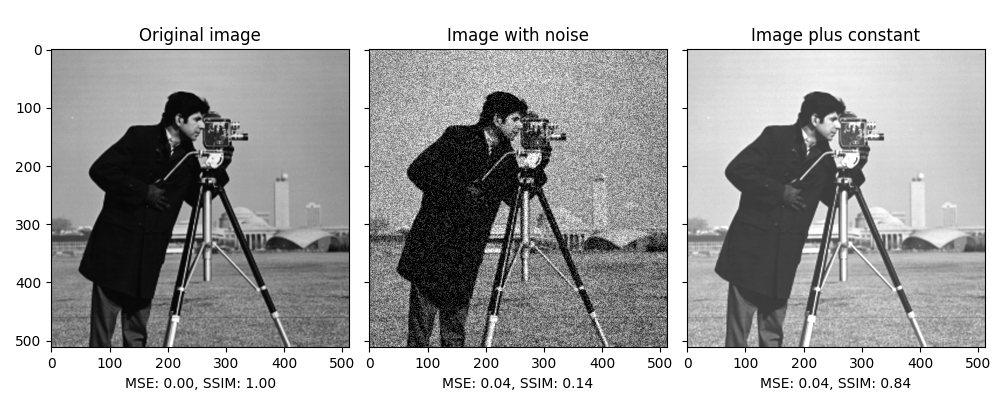

In [14]:
from skimage.metrics import structural_similarity as SSIM

Let's test these functions out.<br>
We know the LR images have been downscaled bicubically, so we can try to upscale them in the same manner, and compare with the original, checking out the resulting metrics.

Let's now build one function that wraps these evaluation metrics in a single container

In [15]:
def evaluate(I,K):
    """
    I     = Original RGB image  I(i,j,k)
    K     = Reference RGB image K(i,j,k)
    
    Return: 
        Dictionary of metrics, MSE, PSNR and SSIM
    """
    
    metrics = {'MSE' : MSE(I,K),
               'PSNR': PSNR(I,K),
               'SSIM': SSIM(I,K,multichannel=True)}
    return metrics

Great, our metrics are in order.

**Update!** Okay I'll need to make versions that handle tensors so we can use them as metrics for our models to monitor during training

In [16]:
import tensorflow.keras.backend as keras
import tensorflow as tf

def mse(y_pred, y_true):
    return tf.keras.losses.MSE(y_true, y_pred)

def psnr(y_pred, y_true):
    return tf.image.psnr(y_pred, 
                         y_true, 
                         max_val=1.0)

# Using ssim_multiscale as it handles image batches
def ssim(y_pred, y_true):
    return tf.image.ssim_multiscale(img1=y_pred, 
                                    img2=y_true, 
                                    max_val=1.0,  
                                    filter_size=4,
                                    filter_sigma=1.5, 
                                    k1=0.01, 
                                    k2=0.03)

## 3.2 Build models

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

def SRCNN():
   
    SRCNN = Sequential()
    
    SRCNN.add(Conv2D(filters=32, kernel_size=(9, 9), strides=(3,3), padding='same', activation='relu',input_shape=(None,None,3)))    
    SRCNN.add(Conv2D(filters=64, kernel_size=(6, 6), strides=(2,2), padding='same', activation='relu'))
    SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
    SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
    SRCNN.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
    SRCNN.add(Conv2DTranspose(filters=3, kernel_size=(2,2), strides=(2,2), padding='same', activation=None))
    
    SRCNN.compile(optimizer=Adam(lr=1e-4), loss='mean_squared_error',metrics=[mse,psnr,ssim])
    SRCNN.build()
    SRCNN.summary()
    
    return SRCNN

In [26]:
srcnn = SRCNN()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, None, None, 32)    7808      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, None, None, 3)     387       
Total params: 174,307
Trainable params: 174,307
Non-trainable params: 0
________________________________________________

<a id='training'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/training.png" alt="Drawing" style="height: 90px;"/>
# 4. Model Training

## 4.1 Getting Acquainted with the Data Handler

So - to deal with data handling for the training process, it became obvious as per section [Loading Data](#load) that we'd face some real issues if we were to load all of the images into memory, as the bicubic datasets and corresponding high-resolution images are some 10.3 GB in size. 

For our training to be successful, we'll need to devise a new data handling strategy.

Looking into the winning paper of the NTIRE17 challenge, titled *[Enhanced Deep Residual Networks for Single Image Super-Resolution](https://arxiv.org/pdf/1707.02921.pdf)* by *B. Lim, S. Son, H. Kim, S. Nah & K.M. Lee*, it soon became apparent that full sized images would not be needed to train the model.

Instead, the model can be trained using only patches from the low resolution images, with the corresponding high-resolution image patches, as stated in Section 4.2 of the paper:

>*For training, we use the RGB input patches of size $48\times48$ from LR image with the corresponding HR patches.*

and they go on to further describe the training process as follows:

>*We augment the training data with random horizontal flips and $90°$ rotations. We pre-process all the images by subtracting the mean RGB value of the DIV2K dataset. We train our model with ADAM optimizer by setting $\beta_1 = 0.9$, $\beta_2 = 0.999$, and $\epsilon = 10^{-8}$. We set minibatch size as 16. The learning rate is initialized as $10^{−4}$ and halved at every $2 \times 10^5$ minibatch updates.*

To design an image patch generator for the training would require some heavy lifting programming. Seeing as I'm allergic to manual labour (🙃), I instead searched for open source code that used the `DIV2K` dataset and soon arrived at [idealo's GitHub](https://idealo.github.io/image-super-resolution/), where they've built an API for image super resolution. Ofcourse, I want the challenge of designing and constructing my own model so I won't be using any of that in this project, but I'd rather spend my time on something more meaningful than crafting a novel data image generator (seeing as the `keras` one won't be of much help).

**Warning!** The next line installs the `ISR` API which will upgrade `TensorFlow` to `v2.0.0`

**Update!** To get `tensorboard` to work in the `Jupyter` notebook environment it seems we should install `tf-nightly` instead of `TensorFlow`

So reading through the source code, we can start figuring out how to go about using these objects, let's begin by creating a datahandler, it's contained in the `./utils` module:

In [27]:
# Import the datahandler class from the .utils module
from ISR.utils import datahandler as ISR_dh

# Define parameters for the training task, let's use 48x48 patches for the x2 downscaled images
lr_patch_size = 48
scale         = 2

# We now create a datahandler for the training, and point it to the location of the LR and HR images
datahandler = ISR_dh.DataHandler(lr_dir = './Datasets/DIV2K_train_LR_bicubic/X2/',
                                 hr_dir = './Datasets/DIV2K_train_HR/',
                                 patch_size = lr_patch_size, 
                                 scale = scale,
                                 n_validation_samples = 1)

Let's then test the datahandler by generating a batch using the `.get_batch` method.<br>
For this, we pass the datahandler the number of images we wish to include in our batch, **AND** a `flatness` criterion which should take a value in the interval $\mathbb{R} \in [0,1]$, which states how *feature less* the image patches are allowed to be. <br>
If we pass $0$, it means any image patch will be accepted, suggesting we could get e.g. an all black patch. <br>
This likely will interfer with our training process and slow down any learning, so let's set a reasonable threshold of 0.1, let's see what this looks like below:

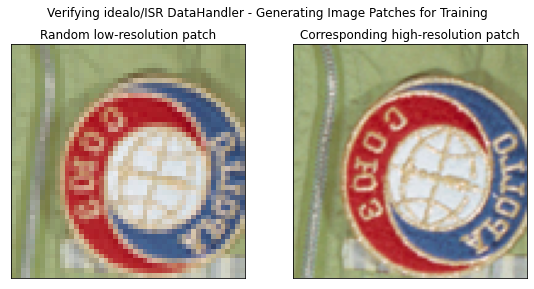

Patch flatness: 0.15308730128242432
LR imageset shape: (4, 48, 48, 3)
HR imageset shape: (4, 96, 96, 3)
Where: (batch_size, width, height, n_channels)


In [28]:
# Get batch
batch = datahandler.get_batch(batch_size = 4, flatness = .1)

# Visualise the result - .get_batch returns a dictionary {'lr':np.arrays[batch_size], 'hr':np.arrays[batch_size]}
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

ax[0].imshow(batch['lr'][0])
ax[0].set_title('Random low-resolution patch')
ax[1].set_title('Corresponding high-resolution patch')
ax[1].imshow(batch['hr'][0])

for plot in ax.ravel():
    plot.set_xticks([])
    plot.set_yticks([])

plt.suptitle('Verifying idealo/ISR DataHandler - Generating Image Patches for Training')
plt.tight_layout()
plt.show()

# Patch flatness: 
print('Patch flatness: {}'.format(max(np.std(batch['lr'][0], axis=0).mean(), np.std(batch['lr'][0], axis=1).mean())))

# Print some shape info
print('LR imageset shape: {}'.format(batch['lr'].shape))
print('HR imageset shape: {}'.format(batch['hr'].shape))
print('Where: (batch_size, width, height, n_channels)')

It seems that the `flatness` parameter is incremented from `0.0` to `0.15` when used in a notebook example by it's designers: 

https://github.com/idealo/image-super-resolution/blob/master/notebooks/ISR_Traininig_Tutorial.ipynb

Search for `flatness`.<br>
**Note** I'll disect this further once we get closer to start training the model and see if we should do the same.

Now bare in mind, this `DataHandler` not only generates these random patches from the images, but also performs augmentation on them. <br>
I'll now verify that this is infact being performed, the augmentation performed is in the form of rotations and flips.

In [29]:
val_batch = datahandler.get_validation_batches(batch_size = 1)

In [30]:
# Check the .img_list property of the data handler, it should hold the validation image filenames
datahandler.img_list

{'hr': array(['0269.png'], dtype='<U8'),
 'lr': array(['0269x2.png'], dtype='<U10')}

Okay this makes sense - let's plot this image

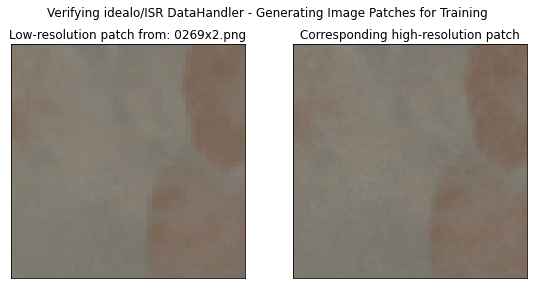

Patch flatness: 0.024086236494282227
LR imageset shape: (1, 48, 48, 3)
HR imageset shape: (1, 96, 96, 3)
Where: (val_batch_size, width, height, n_channels)


In [31]:
# Visualise the result - .get_val_batch returns a dictionary {'lr':np.arrays[val_batch_size], 'hr':np.arrays[val_batch_size]}
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

ax[0].imshow(val_batch[0]['lr'][0])
ax[0].set_title('Low-resolution patch from: {}'.format(datahandler.img_list['lr'][0]))
ax[1].set_title('Corresponding high-resolution patch')
ax[1].imshow(val_batch[0]['hr'][0])

for plot in ax.ravel():
    plot.set_xticks([])
    plot.set_yticks([])

plt.suptitle('Verifying idealo/ISR DataHandler - Generating Image Patches for Training')
plt.tight_layout()
plt.show()

# Patch flatness: 
print('Patch flatness: {}'.format(max(np.std(val_batch[0]['lr'][0], axis=0).mean(), np.std(val_batch[0]['lr'][0], axis=1).mean())))

# Print some shape info
print('LR imageset shape: {}'.format(val_batch[0]['lr'].shape))
print('HR imageset shape: {}'.format(val_batch[0]['hr'].shape))
print('Where: (val_batch_size, width, height, n_channels)')

Okay - by comparing with the original image, it's evident that this is a transformed patch from the original image:

![img](./imgs/0049.png)
![img](./imgs/patch_transformed.png)

## 4.3 Model Management
We want to be able to retrieve previous states so we don't have to train the model from the ground up every time we execute this notebook.<br>
For this, we'll use the `getNewestModel()` function of `Lab_1 MoE` mixture of experts notebook.<br>
This function is constructed to load the latest version of a model, that exists in a given directory.

In [32]:
import os 
from glob import glob

# Get the newest model file within a directory
def getNewestModel(model, dirname):
    # Point at all files in directory
    target = os.path.join(dirname, '*')
    # Get the creation timestamps of the files
    files  = [(f, os.path.getmtime(f)) for f in glob(target)]
    # If the directory is empty there's nothing to load
    if len(files) == 0:
        return model
    # If we find files in the directory 
    else:
        # We sort the model files by time
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        # Grab the newest one
        model.load_weights(newestModel[0])
        # And return it
        return model

We create a directory that will contain the model's training progress

In [33]:
# Name a saving directory for checkpoints
save_dir = "./SRCNN_Model/"

# Create the directory if it doesn't exist
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

We define objects for monitoring early stopping during the training phase and model checkpoints that can be used to resume from previous states. 

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
    
# Early stopping of training
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=5, 
                                        verbose=1, 
                                        mode='auto')

# Creating checkpoint files to save model states
checkpoint = os.path.join(save_dir, 'SRCNN_{val_loss:.2f}.hdf5')

# Output model checkpoint to file
checkpoint_callback = ModelCheckpoint(filepath = checkpoint, 
                                      monitor='loss', 
                                      verbose=1, 
                                      save_best_only=True, 
                                      mode='auto')

# Reduce learning rate if performance metric is plateauing
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", 
                                       factor=0.5, 
                                       patience=2,  
                                       verbose=1,
                                       mode="auto",
                                       cooldown=1,
                                       min_lr=1e-8)

And finally load the latest checkpoint from the directory

In [35]:
# Load the newest model data from the directory if exists
model = getNewestModel(srcnn, save_dir)

## 4.4 Training the Model

Finally we're ready

In [36]:
# Define parameters for the training task, let's use 48x48 patches for the x2 downscaled images
lr_patch_size = 48
scale         = 2
batch_size    = 4

# We now create a datahandler for the training, and point it to the location of the LR and HR images
datahandler = ISR_dh.DataHandler(lr_dir = './Datasets/DIV2K_train_LR_bicubic/X2/',
                                 hr_dir = './Datasets/DIV2K_train_HR/',
                                 patch_size = lr_patch_size, 
                                 scale = scale,
                                 n_validation_samples = 40)

In [37]:
validation_set = datahandler.get_validation_set(batch_size = batch_size)

In [38]:
x_val = validation_set['lr'].astype('float32')
y_val = validation_set['hr'].astype('float32')

In [40]:
import pickle
from time import time
from tensorflow.keras.callbacks import TensorBoard

"""
I N I T I A L I S A T I O N   F O R   T R A I N I N G
"""
# Training settings
total_epochs    = 1
steps_per_epoch = np.floor(800 / batch_size).astype(int)

# Training history
train_history = pd.DataFrame()
val_history   = pd.DataFrame()

# Initialise variable for best model path and validation loss records
best_model_path = './Models/SRCNN/'
losses_location = 'losses/'
losses_filename = 'val_loss'

# Create the directories if they don't exist
if not os.path.isdir(best_model_path):
    os.makedirs(best_model_path)
    
if not os.path.isdir(best_model_path + losses_location):
    os.makedirs(best_model_path + losses_location)  
    
# If a validation record exists we load it
if os.path.exists(best_model_path + losses_location + losses_filename):
    with open(best_model_path + losses_location + losses_filename, 'rb') as file:
        validation_losses     = pickle.load(file)
        best_validation_loss  = validation_losses['val_loss']
        
# Else we start from up high
else:
    best_validation_loss = 1e6
    
"""
L O G G E R
"""
# Print statistics about the training procedure, let user know something is happening before first epoch finishes
print('-'*60+'\n'+'{msg:^60s}'.format(msg="... Initiating Training Session ...") + '\n' + '-'*60)

for epoch in range(total_epochs):
    
    # Define a TensorBoard for visualisation of the training process
    tensorboard = TensorBoard(log_dir='./logs/',
                              histogram_freq=1, 
                              write_graph = True)
    
    # Hook TensorBoard up with our SRCNN model
    tensorboard.set_model(srcnn)
    
    # Start stopwatch
    epoch_start = time()
    
    for step in range(steps_per_epoch):
        
        """
        T R A I N
        """
        # Get a new training batch, n number of image patches set by batch_size
        batch = datahandler.get_batch(batch_size = batch_size, flatness = .1)
        
        # Extract training samples and labels 
        x_train = batch['lr'].astype('float32')
        y_train = batch['hr'].astype('float32')
        
        # Train on batch
        training_losses = srcnn.train_on_batch(x = x_train,
                                               y = y_train)
        
        # Format training losses with descriptive keys for TensorBoard
        training_losses = {'train_'+str(key):val for (key,val) in zip(srcnn.metrics_names,training_losses)}
        
        # Keep history
        train_history = train_history.append(training_losses, ignore_index=True)
    
    """ 
    V A L I D A T E
    """
    # Get validation losses
    validation_losses = srcnn.evaluate(x_val, 
                                       y_val, 
                                       batch_size=batch_size,
                                       verbose=0,
                                       callbacks=[reduce_lr_callback,checkpoint_callback,early_stopping_callback])
    
    # Format validation losses with descriptive key for TensorBoard
    validation_losses = {'val_'+str(key):val for (key,val) in zip(srcnn.metrics_names,validation_losses)}
    
    # Keep history
    val_history = val_history.append(validation_losses, ignore_index=True)
    
    """
    S A V E   B E S T   M O D E L S   -   S T O R E   V A L I D A T I O N   L O S S E S
    """
    if validation_losses['val_loss'] < best_validation_loss:
        # Update best validation loss
        best_validation_loss = validation_losses['val_loss'] 
        # Save the model - I might want to save the weights as well, it might be useful to initialise the x3 / x4 models on the x2 model
        srcnn.save(best_model_path)                         
        print("Best model w/ val loss {l:.6f} saved to {p}".format(l=validation_losses['val_loss'],
                                                                   p=best_model_path))

        with open(best_model_path + losses_location + losses_filename, 'wb') as file:
            pickle.dump(validation_losses, file, protocol=pickle.HIGHEST_PROTOCOL)
    
    #"""
    #D E T E C T   P L A T E A U I N G   M O D E L   P E R F O R M A N C E
    #"""
    #if validation_losses['val_loss'] > best_validation_loss: 
        
    """
    U P D A T E   T E N S O R B O A R D
    """
    
    # Push validation losses to TensorBoard logs
    tensorboard.on_epoch_end(epoch, validation_losses)
    
    # Stop stopwatch
    elapsed_time = time() - epoch_start
    
    """
    L O G G E R
    """
    # Print statistics about the training procedure
    print('-'*60+'\n'+'{msg:^60s}'.format(msg="E P O C H   {e}/{te}").format(e=epoch+1, te=total_epochs) + '\n' + '-'*60)
    msg='Runtime'
    print(f' {msg:25} ==> {elapsed_time:10}s')
    for metric,score in training_losses.items():
        print(f' {metric:25} ==> {score:10}')
    for metric,score in validation_losses.items():
        print(f' {metric:25} ==> {score:10}')
    
# Close TensorBoard
tensorboard.on_train_end(None)

------------------------------------------------------------
            ... Initiating Training Session ...             
------------------------------------------------------------


InvalidArgumentError: Incompatible shapes: [4,16,16,3] vs. [4,96,96,3] [Op:SquaredDifference]

<a id='evaluate'></a>
*Back to [Table of Contents](#toc)*
# 5. Performance Evaluation

## 5.1 Learning Curves

<AxesSubplot:>

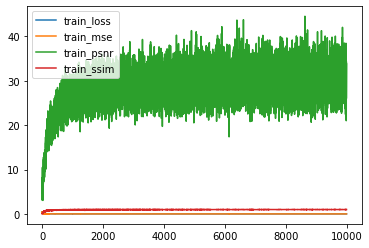

In [27]:
train_history.plot()

In [37]:
train_history.to_pickle(path='./logs/SRCNN-Losses/train_history.pkl')
val_history.to_pickle(path='./logs/SRCNN-Losses/val_history.pkl')

## 5.2 Test Set

In [29]:
x2_bc_test  = loadImages(directory       = './Datasets/DIV2K_valid_LR_bicubic/X2/',
                         file_extension  = '.png',
                         loading_message = 'Loading [x2] Bi-Cubic Downsampled Testing Images ')
y_test      = loadImages(directory       = './Datasets/DIV2K_valid_HR/',
                         file_extension  = '.png',
                         loading_message = 'Loading High Resolution Testing Images \t\t')

Loading [x2] Bi-Cubic Downsampled Testing Images  |████████████████████| 100.0% 
Loading High Resolution Testing Images 		 |████████████████████| 100.0% 


In [30]:
def reshapeImgs(img_arr):
    for i,img in enumerate(img_arr):
        h,w,ch = img.shape
        img = np.reshape(img, (1,h,w,ch))
        img_arr[i] = img / 255.0
    return img_arr

In [31]:
x2_bc_test = reshapeImgs(x2_bc_test)
y_test     = reshapeImgs(y_test)

In [32]:
mse  = 0
psnr = 0
ssim = 0

for sample,label in zip(x2_bc_test, y_test):
    
    y_pred  = srcnn.predict(sample)
    y_pred[y_pred > 1] = 1
    results = evaluate(y_pred[0], label[0])
    
    mse  += results['MSE']
    psnr += results['PSNR']
    ssim += results['SSIM']

n_samples = len(x2_bc_test)

test_scores = {'MSE' : mse  / n_samples,
               'PSNR': psnr / n_samples,
               'SSIM': ssim / n_samples}

/opt/anaconda3/envs/AMLS_II_Final/lib/python3.6/site-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


In [33]:
print('Average metric values on test set:')
print(test_scores)

Average metric values on test set:
{'MSE': 0.0011757192819718538, 'PSNR': 30.90426871116129, 'SSIM': 0.945240564159673}


63


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


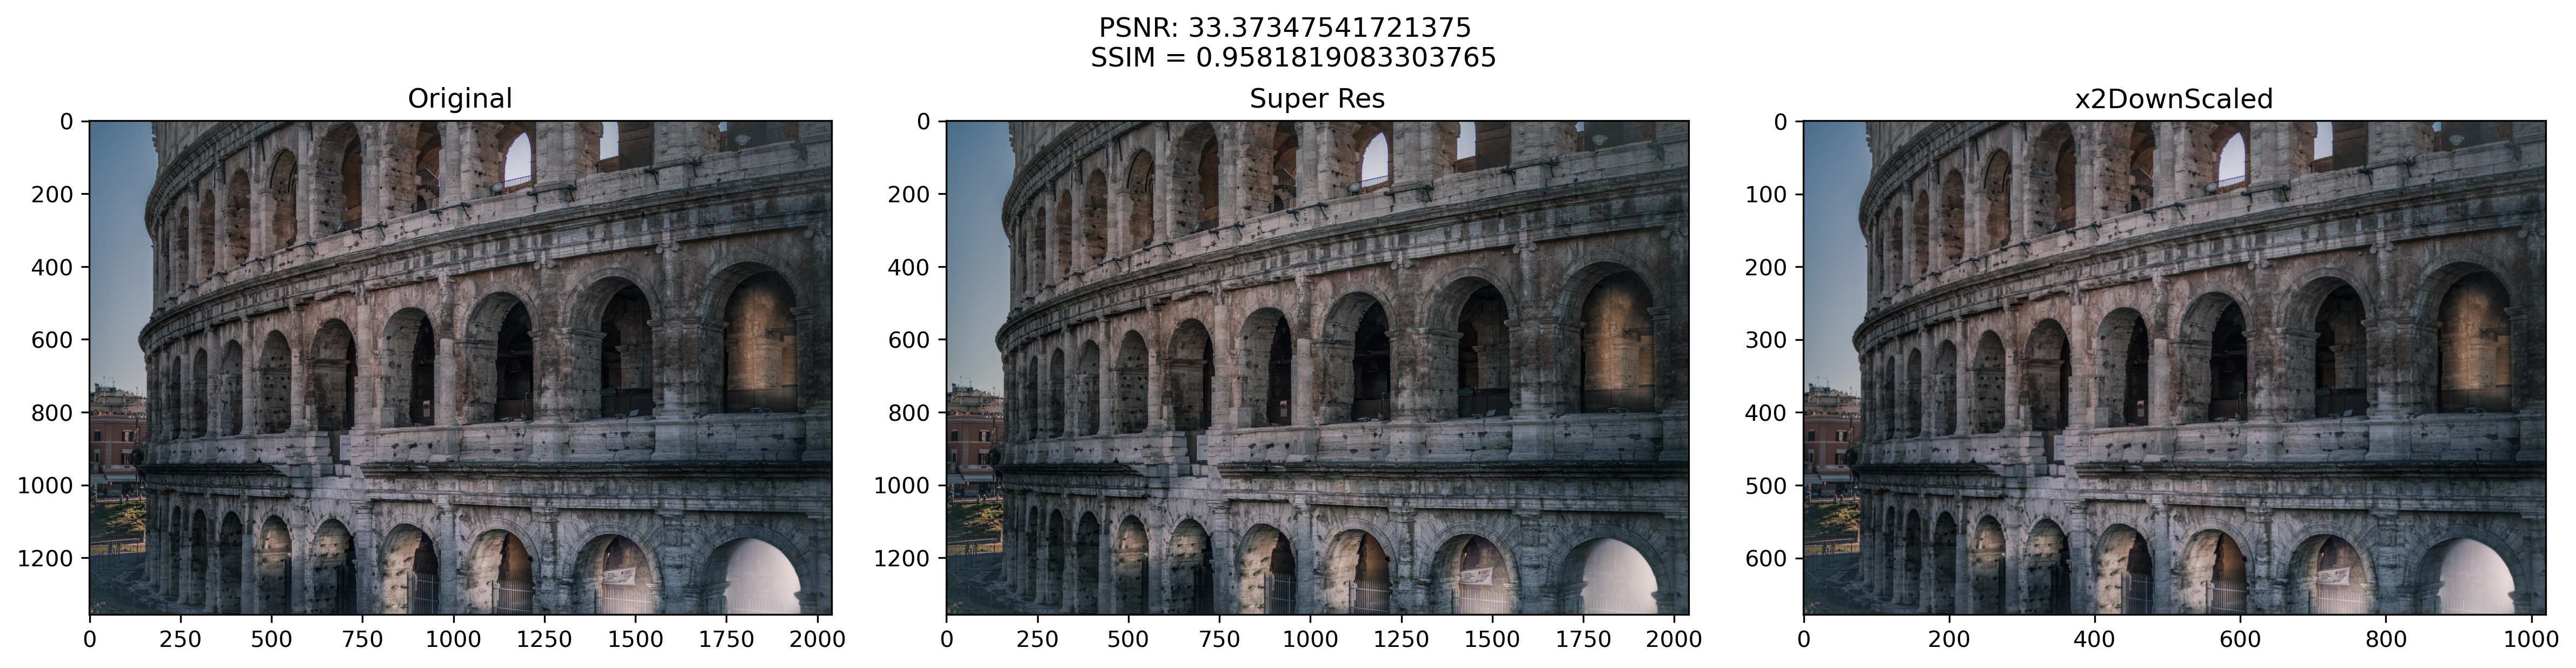

In [34]:
rnd_idx = np.random.randint(low=0, high=n_samples)
print(rnd_idx)

fig,ax = plt.subplots(1,3,figsize=(16,4),dpi=300,sharey=False,sharex=False)
ax[0].imshow(y_test[rnd_idx][0])
ax[0].set_title('Original')

pred_img = srcnn.predict(x2_bc_test[rnd_idx])[0]
pred_img[pred_img > 1.0] = 1.0

ax[1].imshow(pred_img)
ax[1].set_title('Super Res')
ax[2].imshow(x2_bc_test[rnd_idx][0])
ax[2].set_title('x2DownScaled')

#for plot in ax.ravel():
#    plot.set_xticks([])
#    plot.set_yticks([])

rnd_img_metrics = evaluate(pred_img, y_test[rnd_idx][0])

plt.suptitle("PSNR: {psnr} \n SSIM = {ssim}".format(psnr=rnd_img_metrics['PSNR'],ssim=rnd_img_metrics['SSIM']))    
plt.tight_layout()
plt.show()

<a id='credits'></a>
*Back to [Table of Contents](#toc)*
# 6. Credits


Chapter Title Icons: <a href="www.flaticon.com">Flaticon.com</a>. <br>
This notebook has been designed using resources from <a href="www.flaticon.com">Flaticon.com </a>